# Project from scratch with Batchflow

In this tutorial, we show a **complete machine learning project** with **Batchflow**. This code example is an introduction that explains the **main possibilities** of our library.

***Content:***
 * [Task and dataset description](#task_description)
 * [Model configuration](#model_conf)
 * [Training stage](#train) 
 * [Inference stage](#inference)
 * [Metrics](#metrics)
 * [Model representations](#model_representations)
 
And all these things we will make with Batchflow.
So, let's get started!

In [1]:
# Necessary imports
import sys
import warnings
from functools import partial
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

sys.path.append("../../../batchflow")
from batchflow import B, P, R, V, Pipeline
from batchflow import set_gpus, pylint_notebook
from batchflow.models.torch import TorchModel
from batchflow.models.torch.blocks import ResBlock
from batchflow.opensets import ImageWoof2
from batchflow.research.utils import plot_images

_ = set_gpus(1)

`CUDA_VISIBLE_DEVICES` set to "7"


In [2]:
# Parameters
IMAGE_SHAPE = (192, 192)

EPOCH_NUM = 125
FREQUENCY = 50
BATCH_SIZE = 128

<a id='task_description'></a>
## Task and dataset description

We will train a model to **classify** dog breeds. 
We load the [second version of **ImageWoof** dataset](https://github.com/fastai/imagenette#imagewoof), containing 12833 of **ten dog breeds** pictures.
You don't need to download the images by yourself because ImageWoof is already in Batchflow.

A list of **opensets** in Batchflow you can find [here](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html), information about work with **Dataset class** is in [batch operations tutorial](./01_batch_operations.ipynb).

Let's take a closer look at the pictures: they have different shapes, resolutions and contain waste objects.

 50%|█████     | 1/2 [00:15<00:15, 15.50s/it]


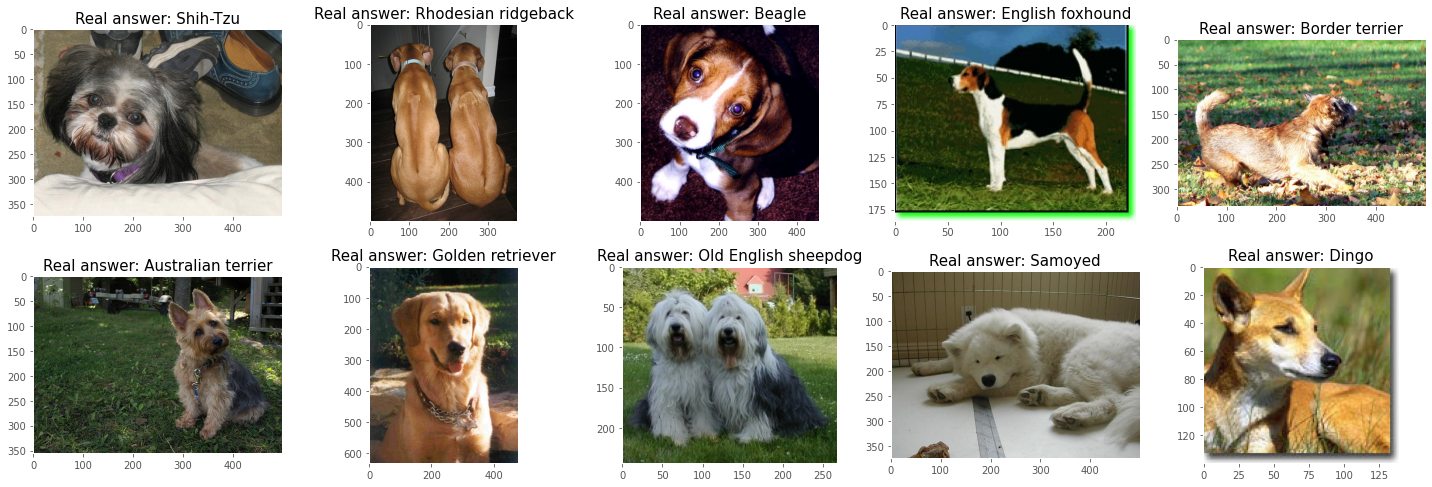

In [3]:
dataset = ImageWoof2(bar='t')

# Get images with different breeds
pic_idx = [np.argwhere(dataset.preloaded[1]==i)[0][0] for i in range(dataset.num_classes)]
plot_images(images=dataset.preloaded[0][pic_idx],
            labels=dataset.preloaded[1][pic_idx],
            ncols=5, classes=dataset.CLASSES,
            figsize=(20, 10), tight_layout=True, fontsize=15)

<a id='model_conf'></a>
## Model configuration

Before training a neural network, we have to define its structure. In the Batchflow, we provide a suitable approach via **model config**.

A **config** contains:
* **initial_block** - block containing the input layers (input stem), which makes **feature extraction**;
* **body** - the main part of the model, which **transforms data**;
* **head** - output layers (global average pooling or dense layers), which **transforms data to preferable output**.

Batchflow has its **own syntax** for defining operations, which helps create models easily. The **base unit** is the [ConvBlock](https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.layers.html#batchflow.models.torch.layers.ConvBlock) which allows us to construct **blocks as sequences of letters-shortcuts** for operations: c - convolution, n - normalization, a - activation, [etc](https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.layers.html#batchflow.models.torch.layers.BaseConvBlock). To create a model, we need to define a config composed of blocks and details such as loss function, optimizer, etc. For **entry in model config creation**, you can look at the [examples](https://analysiscenter.github.io/batchflow/intro/torch_models.html).  

Now, for our task we will describe an **XResNet50** model which is a [**ResNet50** model](https://arxiv.org/pdf/1512.03385.pdf) with several modifications from [bag-of-tricks article](https://arxiv.org/abs/1812.01187): 
 * we replace an input stem with a **ResNet-C** block;
 * as a **Downsample ResBlock** we use a **ResNet-D** block;
 * we initialize **model weights** with kaiming normal;
 * we initialize all **biases** to 0.
 
An **XResNet50 model config** in Batchflow using PyTorch under-the-hood is:

In [4]:
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.optimizer import ranger
from fastai.vision.all import Mish

model_config = {
    # Model info:
    'inputs_shapes': (3, *IMAGE_SHAPE),
    'classes': 10,

    # Model architecture:
    # Input stem is a ResNet-C block
    'initial_block' : {
        'layout': 'cna cna cna p',
        'channels': [32, 32, 64],
        'kernel_size': 3,
        'stride': [2, 1, 1],
        'pool_size': 3,
        'pool_stride': 2,
        'activation': Mish,
        'padding': 1
    },

    'body' : {
        'type': 'encoder',
        'output_type': 'tensor',

        # The body has 16 ResNet blocks grouped into 4 building blocks as in ResNet50
        'num_stages': 16,
        'order': ['block'],
        'blocks': {
            # The model consists of common ResBlocks with a bottleneck:
            'base_block': ResBlock,
            'layout': 'cn',
            'bottleneck': True,

            # We define four building blocks with 3, 4, 6, and 3 ResBlocks
            # that have filters as in ResNet50:
            'channels': [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3,

            # We use the simple self-attention only in the third ResBlock:
            'attention': [False, False, 'ssa'] + [False] * 13,

            # Strides and branches depend on a block type: downsample or not
            # Downsample blocks are ResNet-D blocks with main flow stride=2 and branch layout 'vcn'
            'stride': [1, 1, 1,                                   # First building block
                       2, 1, 1, 1,                                # Second
                       2, 1, 1, 1, 1, 1,                          # Third
                       2, 1, 1],                                  # Fourth

            'branch/layout': ['cn', None, None,
                              'vcn', None, None, None,
                              'vcn', None, None, None, None, None,
                              'vcn', None, None],                 # None refers to identity branches
            'branch/stride': 1,

            # As activations, we use the Mish function:
            'activation': Mish
        }
    },

    'head' : {'layout': 'Vf'},

    # Model training details:
    'init_model_weights': 'best_practice_resnet',
    'loss': LabelSmoothingCrossEntropy(),
    'optimizer': partial(ranger, lr=8e-3, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0., wd=1e-2),
    'output': {'predicted': ['proba', 'labels']}
}

In a model config, we can define **loss** and **optimizer** from Batchflow or other libraries, and here you see the second case example.

This model design refers to the **Encoder** because we solve a **classification** task. If we want to perform **semantic segmentation**, we just need to add a **decoder** in the **config** (and in the **training pipeline**).

This **model config** looks hard to understand the first time, but it will become easier to grasp with experience. So, we hardly recommend reading about [Torch models in Batchflow](https://analysiscenter.github.io/batchflow/intro/torch_models.html#torch-models) and [EncoderDecoder](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.encoder_decoder.html).

<a id='train'></a>
## Training stage

After the model configuration, we need to define the training procedure as a sequence of **pipelines**.

A **pipeline** is a declaration of instructions for **data loading and processing, model training and inference, metrics computations** and so on. The operating principle is simple: pipelines create and process batches that are applied to a model.

The **essential information** about Batchflow pipelines is in the [documentation](https://analysiscenter.github.io/batchflow/intro/pipeline.html) and in the [pipeline operations tutorial](./02_pipeline_operations.ipynb). Tutorials about **model training and inference** you can find by clicking on the links: [PyTorch](./03_ready_to_use_model_torch.ipynb).

In [5]:
# Images preprocessing
load_pipeline = (
    Pipeline()
    .resize(size=IMAGE_SHAPE, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32) # Objects are PIL images, which we need to
                                                  # convert into tensors for our neural network
    .multiply(multiplier=1/255)
)

# Images augmentations
augment_pipeline = (
    Pipeline()
    .flip(mode=P(R(['lr', 'ud'])), p=0.5)
    .crop(origin=P(R('uniform', 0, 1-1e-7, size=2)),
          shape=P(R('integers', int(IMAGE_SHAPE[0]*0.8), IMAGE_SHAPE[0], size=2)),
          crop_boundaries=False, p=0.3)
    .shift(offset=P(R('integers', 20, size=2)), p=0.5)
)

# Model initialization and training instructions
train_model_pipeline = (
    Pipeline()
    .init_variable('loss_history', [])
    .init_model('xresnet50', model_class=TorchModel, mode='dynamic', config=model_config)
    .train_model('xresnet50',
                 inputs=B('images'), targets=B('labels'), outputs='loss',
                 save_to=V('loss_history', mode='a'))
)

# Full training pipeline definition
train_pipeline = (
    augment_pipeline + \
    load_pipeline + \
    train_model_pipeline
) << dataset.train

Our training pipeline is a combination of image **preprocessing**, **augmentations**, and **training process** instructions. More about augmentations can find in the [tutorial](./06_image_augmentation.ipynb).
Letters-shortcuts in pipelines are [named expressions](https://analysiscenter.github.io/batchflow/intro/named_expr.html). They help address data that exists only when the pipeline is executed.

Images from the pipeline have the following look:

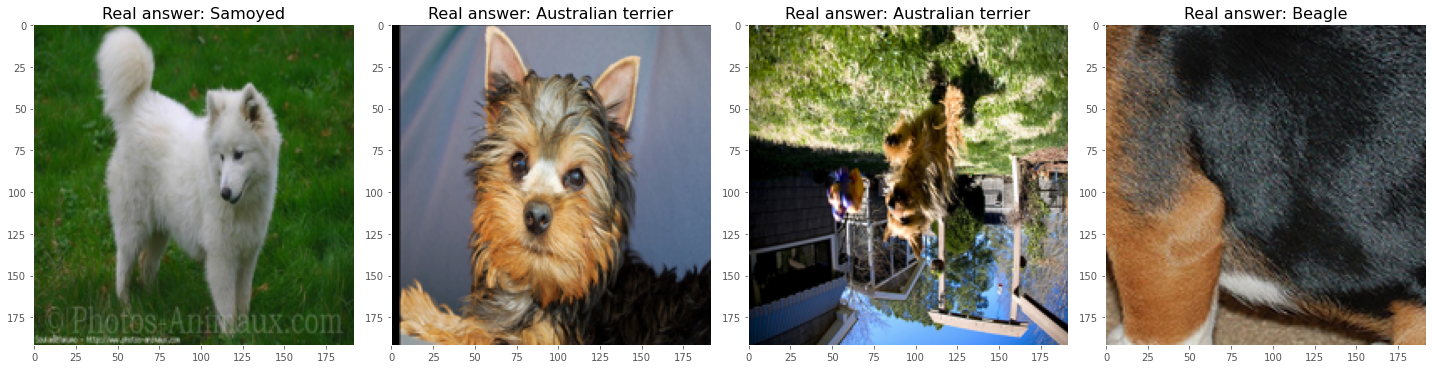

In [6]:
batch = train_pipeline.next_batch(4, shuffle=True)
plot_images(np.transpose(batch.images, (0, 2, 3, 1)), batch.labels,
            classes=dataset.CLASSES, ncols=4,
            figsize=(20, 10), tight_layout=True, fontsize=16)

Pipelines in Batchflow are **lazy**, so we need to call the ```'run'``` method to execute them. The ```'run'``` has additional parameters that allow us to:

* Track the **loss function** (or any other entity) changes during training with a ```notifier```. We can use it for early stopping, as well as for general awareness about pipeline execution.

* Get resource utilization info with a **resources monitor**. This information makes the training process more effective: if you have free **GPU Memory** and **GPU** is not too busy, you can increase batch or model size. (More **about notifier and resources monitor** you can find in the [tracking tutorial](./09_tracking.ipynb)).

* **Inspect timings** for all pipeline actions with [pipelines profiling](./08_profiling.ipynb).

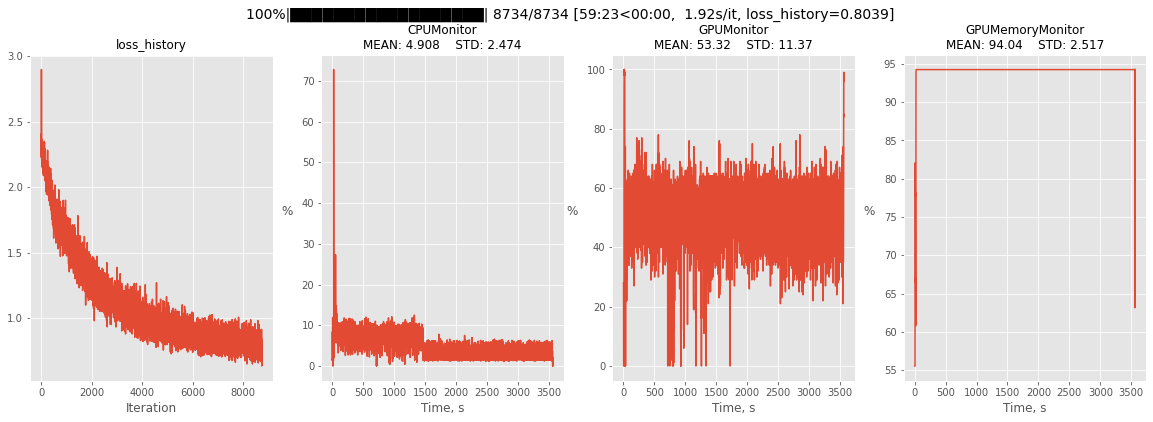

In [7]:
if not os.path.exists('00_tutorial_logs'):
    os.mkdir('00_tutorial_logs')

notifier = {
    'bar': 'n', 'frequency': FREQUENCY,
    'graphs': ['loss_history', 'cpu', 'gpu', 'gpu_memory'],
    'savepath': './00_tutorial_logs/notifier_visualization'
}

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=EPOCH_NUM, shuffle=True,
                       prefetch=10, notifier=notifier)

Model training is successful: **loss function decreases, last iterations have similar loss values, and we use resources efficiently**.

<a id='inference'></a>
## Inference stage

After training, we want to understand how effective the model is.
Thus, the next step is the **model quality measurement**: we define an inference pipeline and compute metrics on the test set.

Two notable **differences between inference and training pipelines** are:
 * inference pipeline doesn't need images **augmentations**;
 * we must provide **metrics** definitions in the inference pipeline.

<a id='metrics'></a>
### Metrics

Firstly, we describe and execute an **inference pipeline**.

In [8]:
metrics_pipeline = (
    Pipeline()
    .init_variables('proba', 'predictions', 'metrics')
    # Model import and getting predictions
    .import_model('xresnet50', train_pipeline)
    .predict_model('xresnet50', inputs=B('images'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
    # Metrics definitions
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=10, axis=1, save_to=V('metrics', mode='update'))
)

# Full inference pipeline
test_pipeline = (
    load_pipeline + \
    metrics_pipeline
) << dataset.test

_ = test_pipeline.run(batch_size=2*BATCH_SIZE, drop_last=False, bar='t')

100%|███████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it]


The pipeline saved information about the **confusion matrix**, and now we can evaluate specific **metrics** from it: possible options are F-measure, accuracy, sensitivity, and more. You can find the description of all **available metrics** in [more](https://analysiscenter.github.io/batchflow/api/batchflow.models.metrics.html).

In [9]:
metrics = test_pipeline.v('metrics')

f1_scores = metrics.evaluate('f1_score', agg='mean', multiclass=None)
print("F1 score for each class:")
print(f1_scores,'\n')
print("Mean F1 score: ", np.mean(f1_scores))

accuracy = metrics.evaluate('accuracy')
print("Accuracy: ", accuracy)

F1 score for each class:
[0.80633374 0.84513806 0.74309979 0.68932039 0.78378378 0.83990148
 0.81065919 0.8489893  0.89438202 0.80412371] 

Mean F1 score:  0.8065731451018042
Accuracy:  0.8128534704370179


Metrics values look decent: **the model often makes accurate predictions**.

We visualize the **confusion matrix** for getting detailed information about **mismatches**.

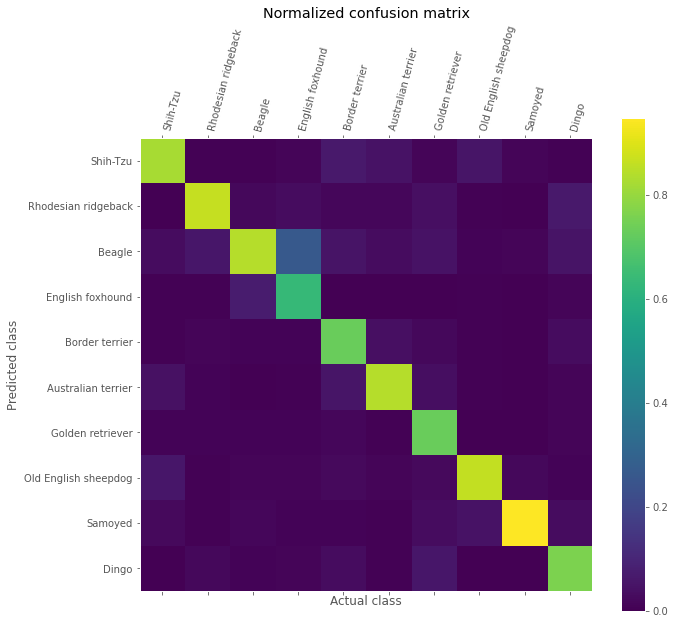

In [10]:
metrics.plot_confusion_matrix(classes=dataset.CLASSES, normalize=True)

The model is most often confused with Beagles and English foxhounds. If you look at pictures of these breeds, you will find that they are similar.

### Visualizations

Of course, it's always interesting to look at some images and model predictions.

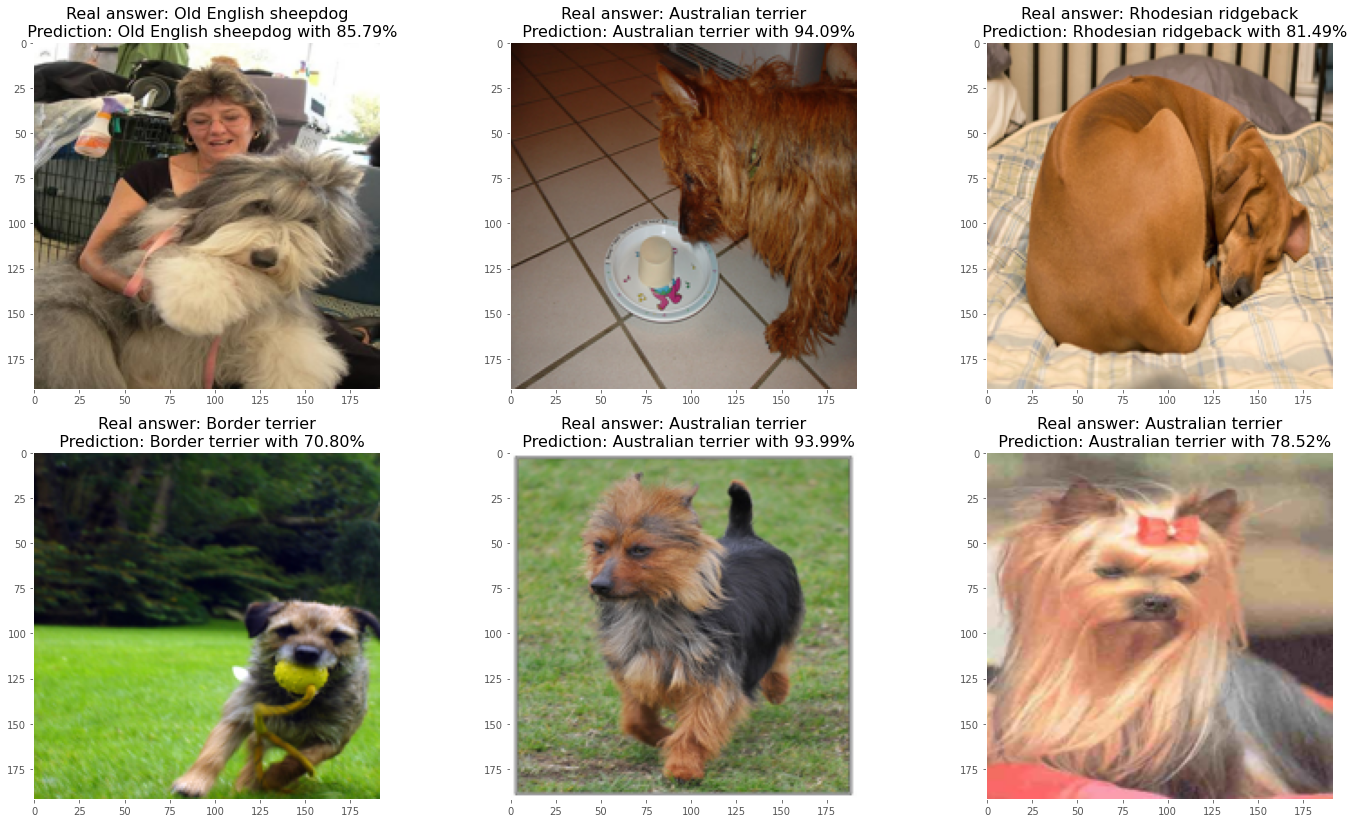

In [11]:
test_pipeline.reset('iter')
batch = test_pipeline.next_batch(6, shuffle=True)

plot_images(np.transpose(batch.images, (0, 2, 3, 1)), batch.labels,
            batch.pipeline.v('proba'), classes=dataset.CLASSES, ncols=3,
            figsize=(20, 17), tight_layout=True, fontsize=16)

From these examples, the model predicts actual labels with high probability. So, **the model recognizes some dog breeds very well**.

<a id='model_representations'></a>
## Model representations

The other curious thing is **model representations**. Batchflow has methods for getting underlying model representations to understand **how the model perceives the data**. This information aid in making model development decisions.

Let's take a look at some insights from **self-attention**. As an **exercise**, you can compare two models with and without self-attention to understand how helpful it is.

In [12]:
model = train_pipeline.get_model_by_name('xresnet50')
module = model.model[1][2] # Self-attention block

We can look at pictures representations that show how the model parts operate with the data.

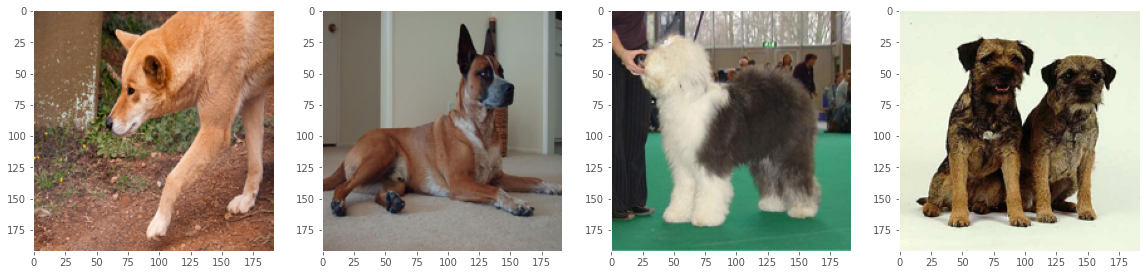

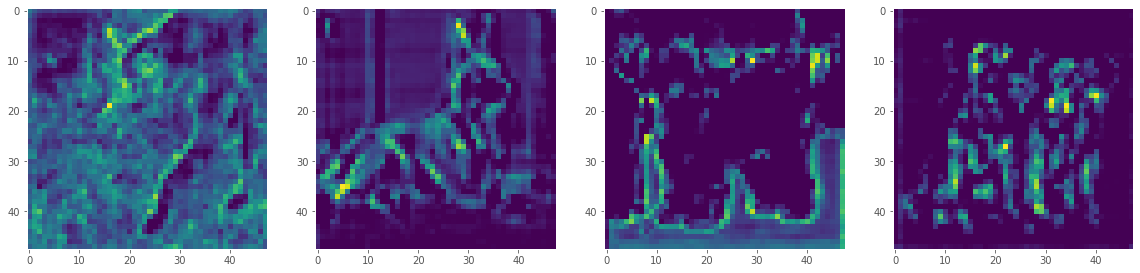

In [13]:
images_num = 4
figsize=(25, 25)
images = []
gradcam_masks = []

batch = test_pipeline.next_batch(images_num, shuffle=True)

for image_num in range(images_num):
    image = np.transpose(batch.images[image_num], (1, 2, 0))
    cam = model.get_gradcam(inputs=batch.images[image_num:image_num+1], layer=module)
    images.append(image.reshape(*image.shape))
    gradcam_masks.append(cam.reshape(*cam.shape, 1))

plot_images(images, figsize=figsize)
plot_images(gradcam_masks, figsize=figsize)

**[Gradcam](https://arxiv.org/pdf/1610.02391.pdf)** highlights **key features** in images.
If the model has good metrics values but frequently strange key features on images -  it's a reason to improve it.
We see that the model on this layer mostly found pictures parts with dogs (sometimes image masks can contain something else and it is normal). This result is what we wanted.

The callable to run the **pylint** tool in **Jupyter Notebook** is a cherry on the cake of this tutorial:

In [14]:
pylint_notebook()

Your code has been rated at -2.38/10 (previous run: -2.54/10, +0.16)
--------------------------------------------------------------------



0

Zero exit code means **no critical errors**. The overall **rating of the code** depends on style guides that are **not** important for Jupyter Notebook, so we don't get the highest mark.

# Conclusion

**In this tutorial, you:**
 * briefly familiarized with the **basic functionality** of Batchflow;
 * learned how to **handle** training and inference processes **efficiently**; 
 * found out ways to get **model insights** to improve your solutions.

# What's next?

After this tutorial, you can easily solve classification challenges with Batchflow. 

**For starters**, you can try other model configurations and augmentations to **improve the current solution** and achieve better metrics values.

We strongly recommend reading other our tutorials after this, as they explain **key concepts** used in this notebook in greater detail.

*If you are confused about the number of links, you can get a shortlist of contents [here](./00_content.ipynb).*